In [1]:
import os
import pathlib
import time
import datetime

from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import json
import random
import csv
import concurrent.futures
from multiprocessing import freeze_support

from keras import layers
from keras import models
from keras import mixed_precision

seed = 6969
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

replays_dir = pathlib.Path("replays")

In [2]:
pre_segment_size = 12
post_segment_size = 12
prediction_size = 8
segment_size = pre_segment_size + post_segment_size + prediction_size

note_size = 49

input_shape = (segment_size, note_size)

batch_size = 256

In [14]:
def get_leaderboard_id_replays(leaderboard_id):
    replay_files = glob.glob(f'{replays_dir}/{leaderboard_id}/*.npy')
    return leaderboard_id, replay_files

def get_leaderboard_replays():
  leaderboard_ids = np.array(tf.io.gfile.listdir(str(replays_dir)))
  random.shuffle(leaderboard_ids)
  val_leaderboard_ids = leaderboard_ids[:int(len(leaderboard_ids)*0.2)]

  train_data = []
  val_data = []
  for leaderboard_id in leaderboard_ids:
    replay_files = glob.glob(f'{replays_dir}/{leaderboard_id}/*.npy')

    if leaderboard_id in val_leaderboard_ids:
      val_data.append((leaderboard_id, replay_files))
    else:
      train_data.append((leaderboard_id, replay_files))

  return train_data, val_data

def get_replay_notes(replay, njs):
  notes = []
  
  prev_zero_note_time = 0
  prev_one_note_time = 0
  
  for note_info, score, note_time in sorted(replay, key=lambda item: item[2]):
    type = note_info[-2]
    
    # NOTE: 0-100 score range is rare and often happens for tracking problems that are not important here
    # would be good to replace this with acc component only and potentially learn all both acc and swing angles
    # but need different format replay files for that
    # score = max(0, score - 100)
    
    delta_to_zero = note_time - prev_zero_note_time
    delta_to_one = note_time - prev_one_note_time
    
    if type == "0":
      prev_zero_note_time = note_time
      note = preprocess_note(score, delta_to_zero, delta_to_one, note_info, njs)
      notes.append(note)
    if type == "1":
      prev_one_note_time = note_time
      note = preprocess_note(score, delta_to_one, delta_to_zero, note_info, njs)
      notes.append(note)
  
  return notes

def preprocess_note(score, delta, delta_other, note_info, njs):
  # NOTE: timing increases difficulty not linearly and caps out at ~2 seconds
  # no idea if such parameters can be learned by neural networks without adding scaling like I did right here
  delta_long = max(0, 2 - delta)/2
  delta_other_long = max(0, 2 - delta_other)/2
  delta_short = max(0, 0.5 - delta)*2
  delta_other_short = max(0, 0.5 - delta_other)*2

  col_number = int(note_info[1])
  row_number = int(note_info[2])
  direction_number = int(note_info[4])

  color = int(note_info[3])

  row_col = [0] * 4 * 3
  direction = [0] * 10
  row_col2 = [0] * 4 * 3
  direction2 = [0] * 10

  row_col[col_number * 3 + row_number] = 1
  direction[direction_number] = 1

  response = []
  
  if color == 0:
      response.extend(row_col)
      response.extend(direction)
      response.extend(row_col2)
      response.extend(direction2)
      response.extend([
          delta_short,
          delta_long,
      ])
      response.extend([
          delta_other_short,
          delta_other_long,
      ])
  if color == 1:
      response.extend(row_col2)
      response.extend(direction2)
      response.extend(row_col)
      response.extend(direction)
      response.extend([
          delta_other_short,
          delta_other_long,
      ])
      response.extend([
          delta_short,
          delta_long,
      ])
  response.extend([
    njs / 30,
    score
  ])
  
  return response

def create_segments(notes):
  empty_res = ([], [])
  if len(notes) < prediction_size:
      return empty_res

  segments = []
  predictions = []
  for i in range(len(notes)-prediction_size+1):
      if i % prediction_size != 0:
          continue
              
      pre_slice = notes[max(0, i-pre_segment_size):i]
      slice = notes[i:i+prediction_size]
      post_slice = notes[i+prediction_size:i+prediction_size+post_segment_size]

      # NOTE: using relative score can be good to find relative difficulty of the notes more fairly
      # because good players will always get higher acc and worse players will do badly even on easy patterns

      pre_segment = [np.array(note[:-1]) for note in pre_slice]
      if len(pre_segment) < pre_segment_size:
          pre_segment[0:0] = [np.zeros(note_size, dtype=np.float32) for i in range(pre_segment_size - len(pre_segment))]
          
      segment = [np.array(note[:-1]) for note in slice]

      post_segment = [np.array(note[:-1]) for note in post_slice]
      if len(post_segment) < post_segment_size:
          post_segment.extend([np.zeros(note_size, dtype=np.float32) for i in range(post_segment_size - len(post_segment))])


      # fix this pls
      prediction = [note[-1] for note in slice]

      final_segment = []
      final_segment.extend(pre_segment)
      final_segment.extend(segment)
      final_segment.extend(post_segment)
      segments.append(final_segment)
      
      predictions.append(prediction)

  return segments, predictions

def to_id(value):
  if int(value) < 30000:
    return str(30000 + int(value))
  return str(int(value))

def preprocess_leaderboard_replays(leaderboard_replays, print_progress=False):
  asd = {}
  replays = []
  
  for leaderboard_replay in leaderboard_replays:
    arr = np.load(leaderboard_replay)
    sort_indices = np.argsort(arr[:, 2])

    # Sort the entire array column-wise based on these indices
    sorted_arr = arr[sort_indices]
    replays.append(sorted_arr)
  
  for replay in replays:
    if len(asd.values()) == 0:
      for values in replay:
        asd[to_id(values[0]) + str(values[2] * 100)] = [to_id(values[0]), [values[1]], values[2], 1]
    else:
      for values in replay:
        key = to_id(values[0]) + str(values[2] * 100)
        if key in asd:
          asd[key][1].append(values[1])
          asd[key][2] += values[2]
          asd[key][3] += 1
  
  asd2 = []
  for values in asd.values():
    if values[3] < 8 or len(values[0]) > 5:
      return ([], [])

    acc_list = values[1]
    acc_list.sort()
    acc = sum(acc_list) / len(acc_list) if len(acc_list) > 0 else 0
    asd2.append([values[0], acc, values[2] / values[3]])
  
  notes = get_replay_notes(asd2, float(leaderboard_replays[0].split("-")[3].replace(".npy", "")))
  return create_segments(notes)


def generate_data(leaderboards_replays):
  segments = []
  scores = []
  
  for (leaderboard_id, leaderboard_replays) in leaderboards_replays:
    segment, score = preprocess_leaderboard_replays(leaderboard_replays)
    if len(segment) == 0: 
      continue

    segments.extend(segment)
    scores.extend(score)
  
  return np.array(segments), np.array(scores)

def clamp(num, lower, higher):
  return min([max([num, lower]), higher])

train_data, val_data = get_leaderboard_replays()
test_data = val_data

train_x, train_y = generate_data(train_data)
val_x, val_y = generate_data(val_data)



In [16]:
from keras import Input, Model
from keras.layers import Bidirectional, LSTM, Concatenate, Cropping1D, TimeDistributed, Dense

# Input layer
input_layer = Input(shape=input_shape, name="input_1")

bidirectional_1 = layers.Bidirectional(layers.LSTM(units=12, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=12, return_sequences=True, go_backwards=True, activation="tanh"))(input_layer)
bidirectional_2 = layers.Bidirectional(layers.LSTM(units=10, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=10, return_sequences=True, go_backwards=True, activation="tanh"))(bidirectional_1)

# Concatenate the output of the second bidirectional LSTM layer with the input
concatenate = Concatenate()([bidirectional_2, input_layer])

# Cropping1D layer
cropping1d = Cropping1D(cropping=(12, 12))(concatenate)  # Adjust the cropping as necessary

# TimeDistributed layer with Dense layer inside
time_distributed_1 = TimeDistributed(Dense(units=16, activation='relu'))(cropping1d)

# Another TimeDistributed layer with Dense layer inside
time_distributed_2 = TimeDistributed(Dense(units=16, activation='relu'))(time_distributed_1)

# Final TimeDistributed layer with Dense layer for output
time_distributed_3 = TimeDistributed(Dense(units=1, activation='linear'), name="time_distributed_2")(time_distributed_2)

# Create the model
model = Model(inputs=input_layer, outputs=time_distributed_3)

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.MeanAbsoluteError(reduction="sum_over_batch_size"),
    metrics=['mae', 'mse'],
)
  
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 32, 49)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 32, 24)    │      5,952 │ input_1[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 32, 20)    │      2,800 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 69)    │          0 │ bidirectional_5[… │
│ (Concatenate)       │                   │            │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d_2        │ (None, 8, 69)     │          0 │ concatenate_2[0]… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 8, 16)     │      1,120 │ cropping1d_2[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 8, 16)     │        272 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 8, 1)      │         17 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,161 (39.69 KB)

 Trainable params: 10,161 (39.69 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

global initial_epoch
initial_epoch = 0

class EpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global initial_epoch
        initial_epoch += 1

def custom_loss(y_true, y_pred):
    return tf.abs(y_true - y_pred)**1

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     monitor='val_mae',
#     filepath=f"models/{'speed' if speed_stuff else 'acc'}/{start_time.strftime('%Y-%m-%d-%H-%M-%S')}",
#     save_best_only=True,
#     save_weights_only=False,
#     verbose=1)


# model2 = tf.keras.models.load_model("model_sleep_lstm_acc", custom_objects={"custom_loss": custom_loss})
# model = tf.keras.models.load_model(f'model_sleep_2gru_{"speed" if speed_stuff else "acc"}')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False),
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True),
    # loss=tf.keras.losses.Huber(delta=5),
    loss='mse',
    metrics=['mae', 'mse'],
)

In [18]:
history = model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    callbacks=[tensorboard_callback, EpochCallback()],
    batch_size=128,
    epochs=initial_epoch + 20,
    initial_epoch=initial_epoch,
    shuffle=True,
    verbose=1,
)

Epoch 1/20
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - loss: 0.0264 - mae: 0.0928 - mse: 0.0264 - val_loss: 0.0053 - val_mae: 0.0528 - val_mse: 0.0053
Epoch 2/20
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - loss: 0.0052 - mae: 0.0522 - mse: 0.0052 - val_loss: 0.0050 - val_mae: 0.0518 - val_mse: 0.0050
Epoch 3/20
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - loss: 0.0050 - mae: 0.0512 - mse: 0.0050 - val_loss: 0.0049 - val_mae: 0.0510 - val_mse: 0.0049
Epoch 4/20
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 0.0049 - mae: 0.0506 - mse: 0.0049 - val_loss: 0.0048 - val_mae: 0.0508 - val_mse: 0.0048
Epoch 5/20
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.0048 - mae: 0.0503 - mse: 0.0048 - val_loss: 0.0048 - val_mae: 0.0506 - val_mse: 0.0048
Epoch 6/20
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - loss: 0.0047 - mae: 0.0499 - mse: 0.0047 - val_loss: 0.0047 - val_mae: 0.0504 - val_mse: 0.0047
Epoch 7/20
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - loss: 0.0046 - mae

In [19]:
import tensorflow as tf
import tf2onnx
import onnx

model.save("model_sleep_bl.keras")

# Convert the saved model to ONNX
spec = (tf.TensorSpec((None, segment_size, note_size), tf.float32, name="input_1"),)
output_path = "model_sleep_bl.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=None, output_path=output_path)

print(f"Model is converted to ONNX and saved at {output_path}")

Model is converted to ONNX and saved at model_sleep_bl.onnx


31fbd91 Sequence Breaker predicted acc - 96.70719909667969 -- real acc 96.35895403295149




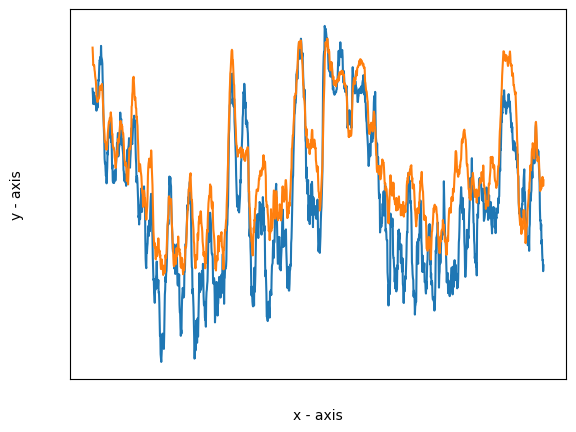

d90a11 watch me dance es predicted acc - 99.24555206298828 -- real acc 99.52214518852358




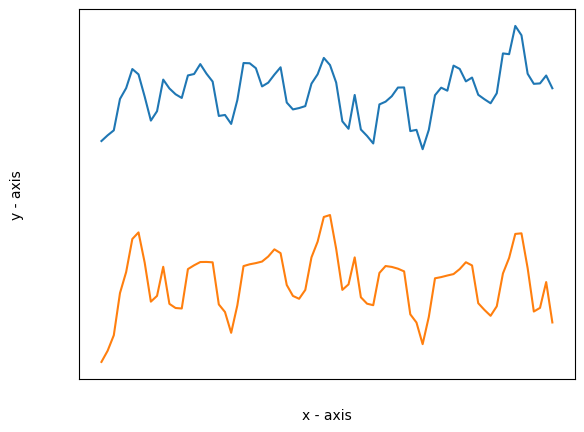

In [9]:
import matplotlib.pyplot as plt
import time

hmm = [
        ["31fbd91", "Sequence Breaker"],
        ["d90a11", "watch me dance es"]]
for val_data_this, map_name in hmm:
    val_xx, val_yy = generate_data([get_leaderboard_id_replays(val_data_this)])
    if len(val_xx) == 0:
        continue

    acc = []
    acc_real = []
    
    speeds = [[], [], []]
    speeds_real = [[], [], []]
    
    complexities = []
    complexities_real = []

    for batch_pred, batch_inp in zip(model(val_xx), val_yy):
        for pred, inp in zip(batch_pred, batch_inp):
            if inp == 0.0:
                continue
            
            acc.append(pred[0])
            acc_real.append(inp)
            
            # for i in range(3):
            #     speeds[i].append(pred[i+1])
            #     speeds_real[i].append(inp[i+1])
            
            # complexities.append(pred[1]*(1-pred[0]))
            # complexities_real.append(inp[1]*(1-inp[0]))


    print(f"{val_data_this} {map_name} predicted acc - {(sum(acc)/len(acc)*15+100)/1.15} -- real acc {(sum(acc_real)/len(acc_real)*15+100)/1.15}")
    # for i in range(3):
    #     print(f"{val_data_this} speed - {sum(speeds[i])/len(speeds[i])} -- {sum(speeds_real[i])/len(speeds_real[i])}")
    # print(f"{val_data_this} complexity - {sum(complexities)/len(complexities)} -- {sum(complexities_real)/len(complexities_real)}")
    
    print("")
    print("")
    
    # complexities = np.convolve(complexities, np.ones(30)/30, mode='valid')
    # speed = np.convolve(speed, np.ones(30)/30, mode='valid')
    # acc = np.convolve([(acc_*15+100)/115 for acc_ in acc], np.ones(30)/30, mode='valid')
    acc_real = np.convolve(acc_real, np.ones(15)/15, mode='valid')
    x = [i for i in range(len(acc_real))]
    plt.plot(x, acc_real)
    acc = np.convolve(acc, np.ones(15)/15, mode='valid')
    x = [i for i in range(len(acc))]
    plt.plot(x, acc)
    
    # plt.plot(x, complexities)
    # for i in range(3):
    #     plt.plot(x, np.convolve(speeds[i], np.ones(30)/30, mode='valid'))
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.show()

In [11]:
predictions = []
for leaderboard_id, leaderboard_replays in test_data:
    try:
      curr, score = preprocess_leaderboard_replays(leaderboard_replays)

      _predictions = model.predict(np.array(curr))

      real_sum = 0
      for prediction in score:
        real_sum += prediction[0]

      real_avg = real_sum/len(score)
      real_percentage_score = (100 + real_avg * 15) / 115

      prediction_sum = 0
      for prediction in _predictions:
        prediction_sum += prediction[0]

      avg = prediction_sum/len(_predictions)
      percentage_score = (100 + avg[0] * 15) / 115

      

      predictions.append([f"https://beatleader.xyz/leaderboard/global/{leaderboard_id}", round(percentage_score, 5), round(real_percentage_score, 5), abs(round(real_percentage_score - percentage_score, 5))])
    except KeyboardInterrupt:
      raise
    except Exception as e:
      print(e)
      continue
with open('predictions.csv', 'w', newline='', encoding='utf-8') as f:
      writer = csv.writer(f)
      header = ["LeaderboardId", "Prediction", "Expected", "Difference"]
      writer.writerow(header)

      for prediction in predictions:
        writer.writerow(prediction)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
math domain error
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
math domain error
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
math domain error
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
math domain error
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
math domain error
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
math domain error
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s